In [1]:
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
import os
from __future__ import division
from numpy.fft import rfft
from numpy import argmax, mean, diff, log, nonzero
from scipy.signal import blackmanharris, correlate

In [12]:
class Wave:
    def __init__ (self, signal, fs):
        self.signal = signal
        self.fs = fs
        
    def __str__ (self):
        return 'Calculated frequency from FFT: ' + str(self.freq_from_fft()) + ' Hz\nCalculated frequency from autocorrelation: ' + str(self.freq_from_autocorr()) + ' Hz'
    
    def freq_from_fft(self):
        """
        Estimate frequency from peak of FFT
        """
        # Compute Fourier transform of windowed signal
        windowed = self.signal * blackmanharris(len(self.signal))
        f = rfft(windowed)

        # Find the peak and interpolate to get a more accurate peak
        i = argmax(abs(f))  # Just use this for less-accurate, naive version
        true_i = self.parabolic(log(abs(f)), i)[0]

        # Convert to equivalent frequency
        return self.fs * true_i / len(windowed)


    def freq_from_autocorr(self):
        """
        Estimate frequency using autocorrelation
        """
        # Calculate autocorrelation and throw away the negative lags
        corr = correlate(self.signal, self.signal, mode='full')
        corr = corr[len(corr)//2:]

        # Find the first low point
        d = diff(corr)
        start = nonzero(d > 0)[0][0]

        # Find the next peak after the low point (other than 0 lag).  This bit is
        # not reliable for long signals, due to the desired peak occurring between
        # samples, and other peaks appearing higher.
        # Should use a weighting function to de-emphasize the peaks at longer lags.
        peak = argmax(corr[start:]) + start
        px, py = self.parabolic(corr, peak)

        return self.fs / px

    def parabolic(self, f, x):
        """Quadratic interpolation for estimating the true position of an
        inter-sample maximum when nearby samples are known.
        f is a vector and x is an index for that vector.
        Returns (vx, vy), the coordinates of the vertex of a parabola that goes
        through point x and its two neighbors.
        Example:
        Defining a vector f with a local maximum at index 3 (= 6), find local
        maximum if points 2, 3, and 4 actually defined a parabola.
        In [3]: f = [2, 3, 1, 6, 4, 2, 3, 1]
        In [4]: parabolic(f, argmax(f))
        Out[4]: (3.2142857142857144, 6.1607142857142856)
        """
        xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
        yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
        return (xv, yv)
    

In [13]:
class Filer:
    def __init__ (self, file_names):
        self.file_names = file_names
        self.open_files()
        self.write_files()
    
    def __str__ (self):
        return str(self.file_names)
    
    def open_files(self):
        self.data = []
        for file in self.file_names:
            df = pd.read_csv('data/' + file + '.csv')
            
            times = df['Time (s)'].values
            n_measurements = len(times)
            timespan_seconds = times[-1] - times[0]
            sample_rate_hz = int(n_measurements / timespan_seconds)
            
            self.data.append([file, df['A-output'].values, df['B-output'].values, sample_rate_hz, times])
            
    def write_files(self):
        for sample in self.data:
            sf.write('wav files/' + sample[0] + '_A-output.wav', sample[1], sample[3])
            sf.write('wav files/' + sample[0] + '_B-output.wav', sample[2], sample[3])
        

In [14]:
class Analyser:
    def __init__ (self, filer):
        self.filer = filer
        self.create_waves()
        
    def __str__ (self):
        return str(self.data)
    
    def create_waves(self):
        self.data = {}
        for i in range(len(self.filer.file_names)):
            name = self.filer.file_names[i]
            
            signal, fs = sf.read('wav files/' + name + "_A-output.wav")
            a = Wave(signal, fs)
            
            signal, fs = sf.read('wav files/' + name + "_B-output.wav")
            b = Wave(signal, fs)
            
            self.data[name] = [a,b]
    
    def get_results(self):
        for sample in self.filer.data:
            name = sample[0]
            print(name)
            print('-----------------------------------------------------')
            print('Analyzing A-output:')
            print(self.data[name][0])
            print('Maximum Acceleration: ' + str(max(abs(sample[1]))) + '\n')
            print('Analyzing B-output:')
            print(self.data[name][1])
            print('Maximum Acceleration: ' + str(max(abs(sample[2]))))
            
            plt.plot(sample[4], sample[1], label = 'A-output')
            plt.plot(sample[4], sample[2], label = 'B-output')
            plt.xlabel('Time (s)')
            plt.ylabel('Acceleration (g)')
            plt.title(sample[0])
            plt.legend(loc='upper right')
            plt.show()
            print('\n')

Improved_NoSnow_05%
-----------------------------------------------------
Analyzing A-output:
Calculated frequency from FFT: 5.355190447391059 Hz
Calculated frequency from autocorrelation: 0.4921078720681766 Hz
Maximum Acceleration: 0.055497

Analyzing B-output:
Calculated frequency from FFT: 0.48943020056394093 Hz
Calculated frequency from autocorrelation: 0.49125133291344447 Hz
Maximum Acceleration: 0.072203


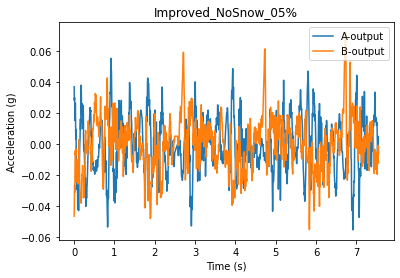



Improved_NoSnow_10%
-----------------------------------------------------
Analyzing A-output:
Calculated frequency from FFT: 6.1623008397916434 Hz
Calculated frequency from autocorrelation: 1.2323205259200507 Hz
Maximum Acceleration: 0.151496

Analyzing B-output:
Calculated frequency from FFT: 1.2074297419960853 Hz
Calculated frequency from autocorrelation: 1.2338428489451105 Hz
Maximum Acceleration: 0.184056


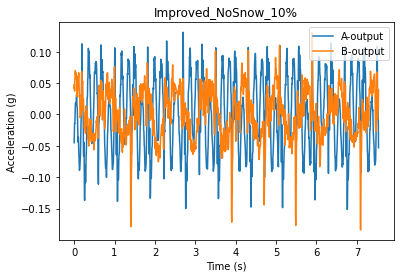



Improved_NoSnow_15%
-----------------------------------------------------
Analyzing A-output:
Calculated frequency from FFT: 6.2029676554067725 Hz
Calculated frequency from autocorrelation: 1.2398938375269566 Hz
Maximum Acceleration: 0.149179

Analyzing B-output:
Calculated frequency from FFT: 1.2449878137535486 Hz
Calculated frequency from autocorrelation: 1.2393730071194116 Hz
Maximum Acceleration: 0.165775


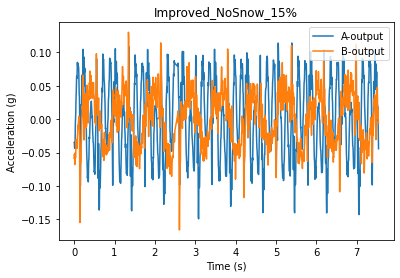



Improved_NoSnow_20%
-----------------------------------------------------
Analyzing A-output:
Calculated frequency from FFT: 5.4218393509576215 Hz
Calculated frequency from autocorrelation: 1.805283181717666 Hz
Maximum Acceleration: 0.361876

Analyzing B-output:
Calculated frequency from FFT: 3.3250104660647417 Hz
Calculated frequency from autocorrelation: 1.7149829393054854 Hz
Maximum Acceleration: 0.35067


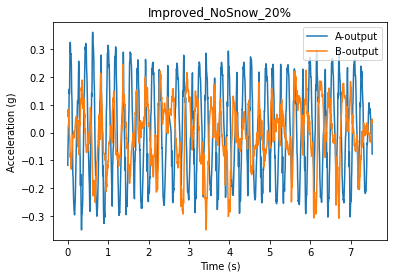



Improved_NoSnow_25%
-----------------------------------------------------
Analyzing A-output:
Calculated frequency from FFT: 5.778955927903367 Hz
Calculated frequency from autocorrelation: 1.9251068472546609 Hz
Maximum Acceleration: 0.26795

Analyzing B-output:
Calculated frequency from FFT: 1.926152379195297 Hz
Calculated frequency from autocorrelation: 1.9457792879020124 Hz
Maximum Acceleration: 0.276383


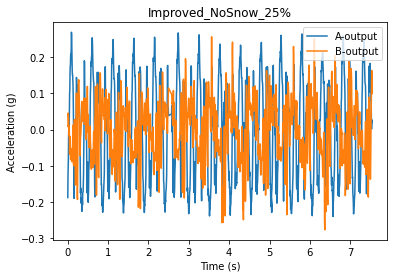



Improved_NoSnow_30%
-----------------------------------------------------
Analyzing A-output:
Calculated frequency from FFT: 5.996385784189214 Hz
Calculated frequency from autocorrelation: 1.9989280904587081 Hz
Maximum Acceleration: 0.233117

Analyzing B-output:
Calculated frequency from FFT: 1.995991474564254 Hz
Calculated frequency from autocorrelation: 0.995277040371507 Hz
Maximum Acceleration: 0.340745


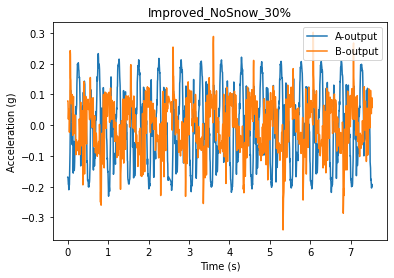



Improved_NoSnow_35%
-----------------------------------------------------
Analyzing A-output:
Calculated frequency from FFT: 2.045513833275368 Hz
Calculated frequency from autocorrelation: 2.047555584618849 Hz
Maximum Acceleration: 0.230931

Analyzing B-output:
Calculated frequency from FFT: 2.048477568010123 Hz
Calculated frequency from autocorrelation: 2.0273732177038357 Hz
Maximum Acceleration: 0.310518


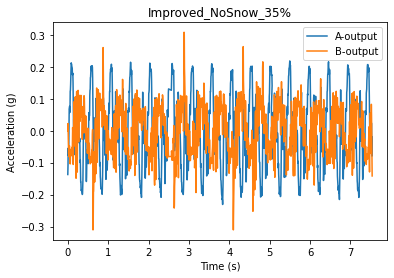



Improved_NoSnow_40%
-----------------------------------------------------
Analyzing A-output:
Calculated frequency from FFT: 2.078556088962893 Hz
Calculated frequency from autocorrelation: 2.0806913581075084 Hz
Maximum Acceleration: 0.227379

Analyzing B-output:
Calculated frequency from FFT: 2.087570522877966 Hz
Calculated frequency from autocorrelation: 2.065491413127395 Hz
Maximum Acceleration: 0.341834


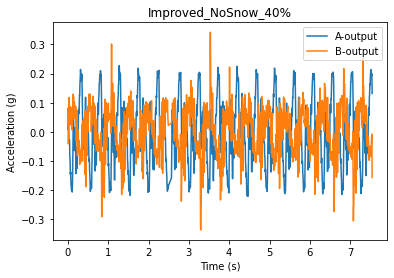



Improved_Snow_05%
-----------------------------------------------------
Analyzing A-output:
Calculated frequency from FFT: 3.3285772540377523 Hz
Calculated frequency from autocorrelation: 0.4749661964451648 Hz
Maximum Acceleration: 0.033618

Analyzing B-output:
Calculated frequency from FFT: 0.48422868001239877 Hz
Calculated frequency from autocorrelation: 0.47429466764446016 Hz
Maximum Acceleration: 0.063228


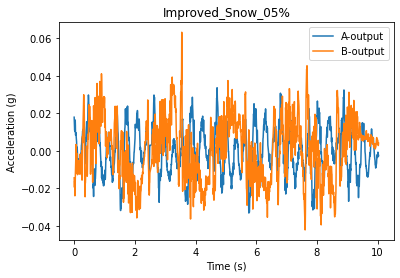



Improved_Snow_10%
-----------------------------------------------------
Analyzing A-output:
Calculated frequency from FFT: 1.192313208499208 Hz
Calculated frequency from autocorrelation: 0.5961452275064651 Hz
Maximum Acceleration: 0.111814

Analyzing B-output:
Calculated frequency from FFT: 1.2019362246316703 Hz
Calculated frequency from autocorrelation: 1.1930843551078525 Hz
Maximum Acceleration: 0.182057


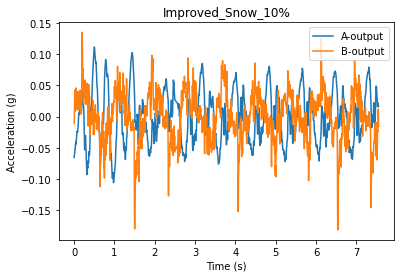



Improved_Snow_15%
-----------------------------------------------------
Analyzing A-output:
Calculated frequency from FFT: 1.5869921921680061 Hz
Calculated frequency from autocorrelation: 1.5866796572278539 Hz
Maximum Acceleration: 0.126387

Analyzing B-output:
Calculated frequency from FFT: 1.581224326794939 Hz
Calculated frequency from autocorrelation: 1.5748332932187132 Hz
Maximum Acceleration: 0.239434


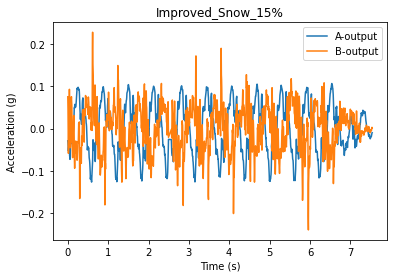



Improved_Snow_20%
-----------------------------------------------------
Analyzing A-output:
Calculated frequency from FFT: 1.8054753036741318 Hz
Calculated frequency from autocorrelation: 1.8061777222612552 Hz
Maximum Acceleration: 0.170009

Analyzing B-output:
Calculated frequency from FFT: 1.7955143586776114 Hz
Calculated frequency from autocorrelation: 1.6844073218057054 Hz
Maximum Acceleration: 0.358776


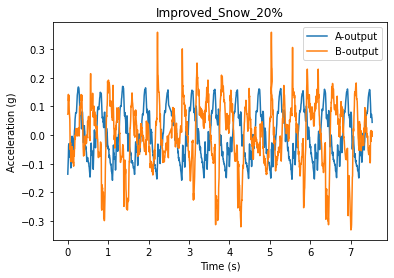



Improved_Snow_25%
-----------------------------------------------------
Analyzing A-output:
Calculated frequency from FFT: 1.9076901932822041 Hz
Calculated frequency from autocorrelation: 1.9074939360983347 Hz
Maximum Acceleration: 0.199896

Analyzing B-output:
Calculated frequency from FFT: 1.9120690802807019 Hz
Calculated frequency from autocorrelation: 1.944477075595439 Hz
Maximum Acceleration: 0.293215


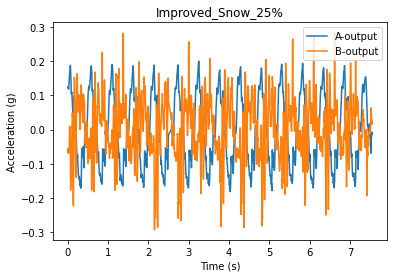



Improved_Snow_30%
-----------------------------------------------------
Analyzing A-output:
Calculated frequency from FFT: 1.988691383766001 Hz
Calculated frequency from autocorrelation: 1.988279564654957 Hz
Maximum Acceleration: 0.220277

Analyzing B-output:
Calculated frequency from FFT: 1.9927196230948845 Hz
Calculated frequency from autocorrelation: 1.9750712273991426 Hz
Maximum Acceleration: 0.333564


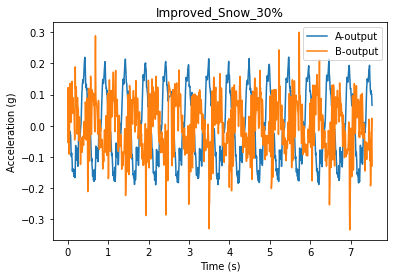



Improved_Snow_35%
-----------------------------------------------------
Analyzing A-output:
Calculated frequency from FFT: 2.032795881652168 Hz
Calculated frequency from autocorrelation: 2.0345827668174414 Hz
Maximum Acceleration: 0.22008

Analyzing B-output:
Calculated frequency from FFT: 2.034416001533485 Hz
Calculated frequency from autocorrelation: 1.0230488446754011 Hz
Maximum Acceleration: 0.372123


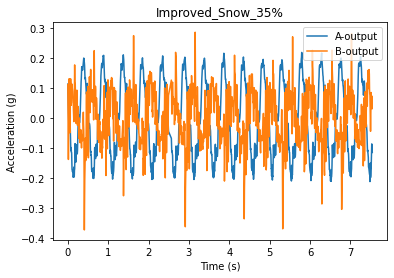



Improved_Snow_40%
-----------------------------------------------------
Analyzing A-output:
Calculated frequency from FFT: 2.0820396636783145 Hz
Calculated frequency from autocorrelation: 2.0838280294035942 Hz
Maximum Acceleration: 0.253874

Analyzing B-output:
Calculated frequency from FFT: 2.080023341190805 Hz
Calculated frequency from autocorrelation: 1.0400031525926006 Hz
Maximum Acceleration: 0.3779


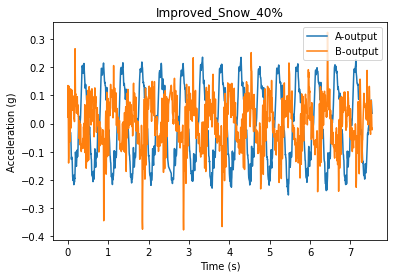

In [31]:
files = os.listdir('data')
for i in range(len(files)):
    files[i] = files[i][:-4]
    
f = Filer(files)
a = Analyser(f)
a.get_results()